In [168]:
import numpy as np
import scipy as sp
import scipy.io as sio
import matplotlib.pyplot as plt
from PIL import Image
import random as rand
import pathlib
from shutil import copyfile
import os
import random
from IPython.display import display
import imageio

In [169]:
os.chdir('/Users/kev/Code/classes/cmsc498m/Project1/notebooks')

In [170]:
def stylize_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_tick_params(top='off', direction='out', width=1)
    ax.yaxis.set_tick_params(right='off', direction='out', width=1)

## Importing Data and Saving Images

In [171]:
DATAPATH = '../data/'

# Create data directories
pathlib.Path(DATAPATH + 'interim/data').mkdir(parents=True, exist_ok=True)
pathlib.Path(DATAPATH + 'interim/illumination').mkdir(parents=True, exist_ok=True)
pathlib.Path(DATAPATH + 'interim/pose').mkdir(parents=True, exist_ok=True)
pathlib.Path(DATAPATH + 'processed/data').mkdir(parents=True, exist_ok=True)
pathlib.Path(DATAPATH + 'processed/illumination').mkdir(parents=True, exist_ok=True)
pathlib.Path(DATAPATH + 'processed/pose').mkdir(parents=True, exist_ok=True)

In [172]:
# Recover image from vector
def recover_img(v, dim1=40, dim2=48, rotate=270):
    rescaled = v.reshape(dim1, dim2)
    return Image.fromarray(rescaled).rotate(rotate, expand=True)

In [173]:
# Load illumination: cropped 40x48 (1920px) images of 68 subjects under 21 different illuminations
illum_dat = sio.loadmat(DATAPATH + '/raw/illumination.mat')
illum_mat = illum_dat['illum']

# Save images as person_67_illum_20.tif
for illum in range(illum_mat.shape[1]):
    for person in range(illum_mat.shape[2]):
        # Create class folder
        person_no, illum_no = '{0:0=2d}'.format(person), '{0:0=2d}'.format(illum)
        pathlib.Path(DATAPATH + 'interim/illumination/person{0}'.format(person_no)).mkdir(parents=True, exist_ok=True)
        # Create and save image
        img = recover_img(illum_mat[:,illum,person])
        filename = 'person{0}_illum{1}.tif'.format(person_no, illum_no)
        img.save(DATAPATH + 'interim/illumination/person{0}/{1}'.format(person_no, filename))

### Train/Test Split

In [174]:
# Check if image is Tif
def isTif(filename): return filename.endswith(".tif") and '.ipynb_checkpoints' not in filename

# Create test/train split
random.seed(999)
split = 0.8  # 80% of 21 illuminations will be ceilinged to 17, or ~81%
train, test = [], []
subdir = DATAPATH + 'interim/illumination/'
dirs = next(os.walk(subdir))[1]  # class folders

for dir in dirs:
    filenames = os.listdir(subdir + dir)
    img_filenames = [filename for filename in filenames if isTif(filename)]
    img_filepaths = [subdir + dir + os.sep + img_filename for img_filename in img_filenames]
    random.shuffle(img_filepaths) # shuffle class images so train/test have same distribution
    train = train + img_filepaths[:int(split*len(img_filenames))]
    test = test + img_filepaths[int(split*len(img_filenames)):]

## Preprocessing

In [175]:
def load_image(filepath):
    return imageio.imread(filepath).flatten(order='F')  # column-major flatten

Text(0.5,1,'person03_illum16.tif')

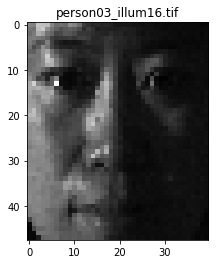

In [176]:
# Load first training image
v = load_image(test[0])
img = recover_img(v)
plt.imshow(img)
plt.title(test[i].split('/')[-1])

Text(0.5,0.98,'16 Images from Training Set')

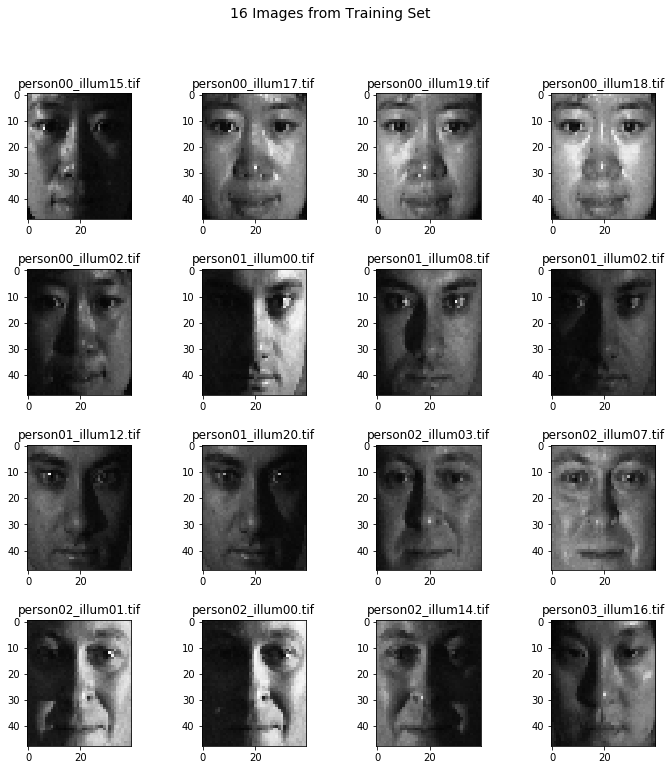

In [177]:
cols, rows = 4, 4
scale = 3
fig = plt.figure(figsize=(cols*scale,rows*scale))
for i in range(cols*rows):
    fig.add_subplot(rows,cols,i+1)
    v = load_image(test[i])
    img = recover_img(v).convert('RGBA')
    plt.imshow(img)
    plt.title(test[i].split('/')[-1])
    plt.subplots_adjust(hspace = 0.4)
fig.suptitle('16 Images from Training Set', fontsize=14)
# fig.tight_layout

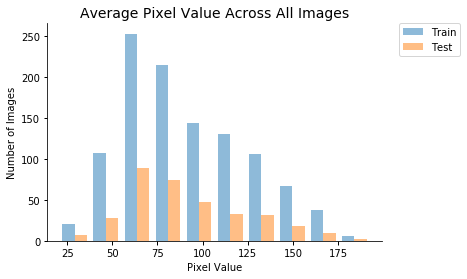

In [178]:
def average_pixels(dataset):
    average_pixels = []
    for filename in dataset:
        v = load_image(filename)
        average_pixels.append(np.mean(v))
    return average_pixels

# Plot average pixels
fig, ax = plt.subplots()
plt.hist([average_pixels(train), average_pixels(test)], alpha=0.5, label=['Train','Test'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Average Pixel Value Across All Images', fontsize=14)
plt.xlabel('Pixel Value')
plt.ylabel('Number of Images')
stylize_axes(ax)

Text(0.5,0.98,'Average Images from Training and Test Sets')

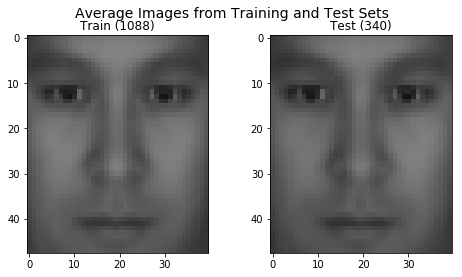

In [179]:
def average_image(dataset):
    average_image = [0]
    for filename in dataset:
        average_image += load_image(filename)
    average_image /= len(dataset)
    return average_image

# Plot Average Images
cols, rows = 2, 1
scale = 4
fig = plt.figure(figsize=(cols*scale,rows*scale))

fig.add_subplot(rows,cols,1)
img = recover_img(average_image(train))
plt.imshow(img)
plt.title('Train (1088)')

fig.add_subplot(rows,cols,2)
img = recover_img(average_image(test))
plt.imshow(img)
plt.title('Test (340)')

plt.subplots_adjust(hspace = 0.4)
fig.suptitle('Average Images from Training and Test Sets', fontsize=14)

In [180]:
# Mean center and save images into train/test splits
average_train = average_image(train)
def center_image(filename):
    v = load_image(filename)
    return v - average_train

pathlib.Path(DATAPATH + 'processed/illumination/train').mkdir(parents=True, exist_ok=True)
pathlib.Path(DATAPATH + 'processed/illumination/test').mkdir(parents=True, exist_ok=True)

for filename in train:
    chunks = filename.split('/')
    # create class folder
    pathlib.Path(DATAPATH + 'processed/illumination/train/' + chunks[-2]).mkdir(parents=True, exist_ok=True)
    # center image and create new file
    new_filepath = '/'.join(["../data/processed/illumination/train"] + chunks[-2:])
    img = recover_img(center_image(filename))
    img.save(new_filepath)
    
for filename in test:
    chunks = filename.split('/')
    # create class folder 
    pathlib.Path(DATAPATH + 'processed/illumination/test/' + chunks[-2]).mkdir(parents=True, exist_ok=True)
    # center image and create new file
    new_filepath = '/'.join(["../data/processed/illumination/test"] + chunks[-2:])
    img = recover_img(center_image(filename))
    img.save(new_filepath)